<a href="https://colab.research.google.com/github/TrevinWacker/NLP-practice/blob/main/Challenge_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HuffPo article subject classification**

---
The goal of this project is to classify different articles by headline in order to quickly sort into general interest categories.  This could be used by HuffPo editors to streamline categorization for their own purposes, and could even suggest unconsidered classification options for an article.


I'm looking at large conglomeration of Huffington Post articles published between 2012 and 2018, found on [Kaggle](https://www.kaggle.com/rmisra/news-category-dataset).  I'll be examining the `headline` feature & `short_description` in seperate models and assess whether their are signficant differences in performance.  If we are able to get similarly accurate results using just `headline`, this would be very beneficial towards limiting time and required processing power.  

In the interest of time and my current processing capability, I'll only be looking at articles published in 2018.  Time may be a factor in categorization (more 'queer stories' articles may appear in June vs other months, for example).  I will therefore consider this to be a further factor to enhance this model in the future and will not incorporate it into this project.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import spacy
import datetime as dt
import re
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

In [6]:
# Gather data
df = pd.read_json("News_Category_Dataset_v2.json", lines=True)
huffpo_df = df.copy()

# Remove unincorporated features
huffpo_df.drop(["authors", "link"], axis=1, inplace=True)

# Limiting scope to just articles from 2018
huffpo_df = huffpo_df[huffpo_df['date'].dt.year == 2018]
print("Length of dataframe: {}".format(huffpo_df.shape[0]))

huffpo_df.info()
print("Length of df: {}".format(huffpo_df.shape[0]))

Length of dataframe: 8583
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8583 entries, 0 to 8582
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category           8583 non-null   object        
 1   headline           8583 non-null   object        
 2   short_description  8583 non-null   object        
 3   date               8583 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 335.3+ KB
Length of df: 8583


In [7]:
def full_clean(text):
  # Removes forms of punctuation spaCy doesn't recognize
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)
    text = ' '.join(text.split())

    # Removes emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [8]:
# Load nlp object
nlp = spacy.load('en', disable=["parser", "ner"])
nlp.create_pipe("sentencizer")
nlp.max_length = 25000000

In [9]:
#Put nlp features into dataframe

# I was unable to directly input these values into features, so I'm using a workaround by turning these into lists and then assigning them to a feature
# Creating lists
clean_headlines = []
for i in range(huffpo_df.shape[0]):
  clean_headlines.append(nlp(full_clean(huffpo_df.iloc[i]["headline"])))

clean_descriptions = []
for i in range(huffpo_df.shape[0]):
  clean_descriptions.append(nlp(full_clean(huffpo_df.iloc[i]["short_description"])))


# Assign to features
huffpo_df["clean_headline"] = clean_headlines
huffpo_df["clean_desc"] = clean_descriptions

# Drop non-cleaned features
huffpo_df.drop(["headline", "short_description"], 1, inplace=True)

# I'm also converting the date to just the month for data exploration.
huffpo_df.date = huffpo_df.date.dt.month
huffpo_df.rename(columns={"date":"month"}, inplace=True)

huffpo_df.head()

,category,month,clean_headline,clean_desc
0,CRIME,5,"(There, Were, Mass, Shootings, In, Texas, Last...","(She, left, her, husband, ., He, killed, their..."
1,ENTERTAINMENT,5,"(Will, Smith, Joins, Diplo, And, Nicky, Jam, F...","(Of, course, it, has, a, song, .)"
2,ENTERTAINMENT,5,"(Hugh, Grant, Marries, For, The, First, Time, ...","(The, actor, and, his, longtime, girlfriend, A..."
3,ENTERTAINMENT,5,"(Jim, Carrey, Blasts, ', Castrato, ', Adam, Sc...","(The, actor, gives, Dems, an, ass, -, kicking,..."
4,ENTERTAINMENT,5,"(Julianna, Margulies, Uses, Donald, Trump, Poo...","(The, "", Dietland, "", actress, said, using, th..."


In [10]:
# Get rid of stop words and punctuation and lemmatize the tokens
for i, word in enumerate(huffpo_df["clean_headline"]):
    huffpo_df.loc[i, "clean_headline"] = " ".join(
        [token.lemma_ for token in word if not token.is_punct and not token.is_stop])
    
for i, word in enumerate(huffpo_df["clean_desc"]):
    huffpo_df.loc[i, "clean_desc"] = " ".join(
        [token.lemma_ for token in word if not token.is_punct and not token.is_stop])
  
huffpo_df.head()

,category,month,clean_headline,clean_desc
0,CRIME,5,Mass shooting Texas Week tv,leave husband kill child day America
1,ENTERTAINMENT,5,Smith Joins Diplo Nicky Jam World Cup official...,course song
2,ENTERTAINMENT,5,Hugh Grant marrie Time Age,actor longtime girlfriend Anna Eberstein tie k...
3,ENTERTAINMENT,5,Jim Carrey Blasts Castrato Adam Schiff Democra...,actor give Dems ass kick fight hard Donald Trump
4,ENTERTAINMENT,5,Julianna Margulies use Donald Trump Poop bag p...,Dietland actress say bag cathartic therapeutic...


---

**Data Exploration**

---

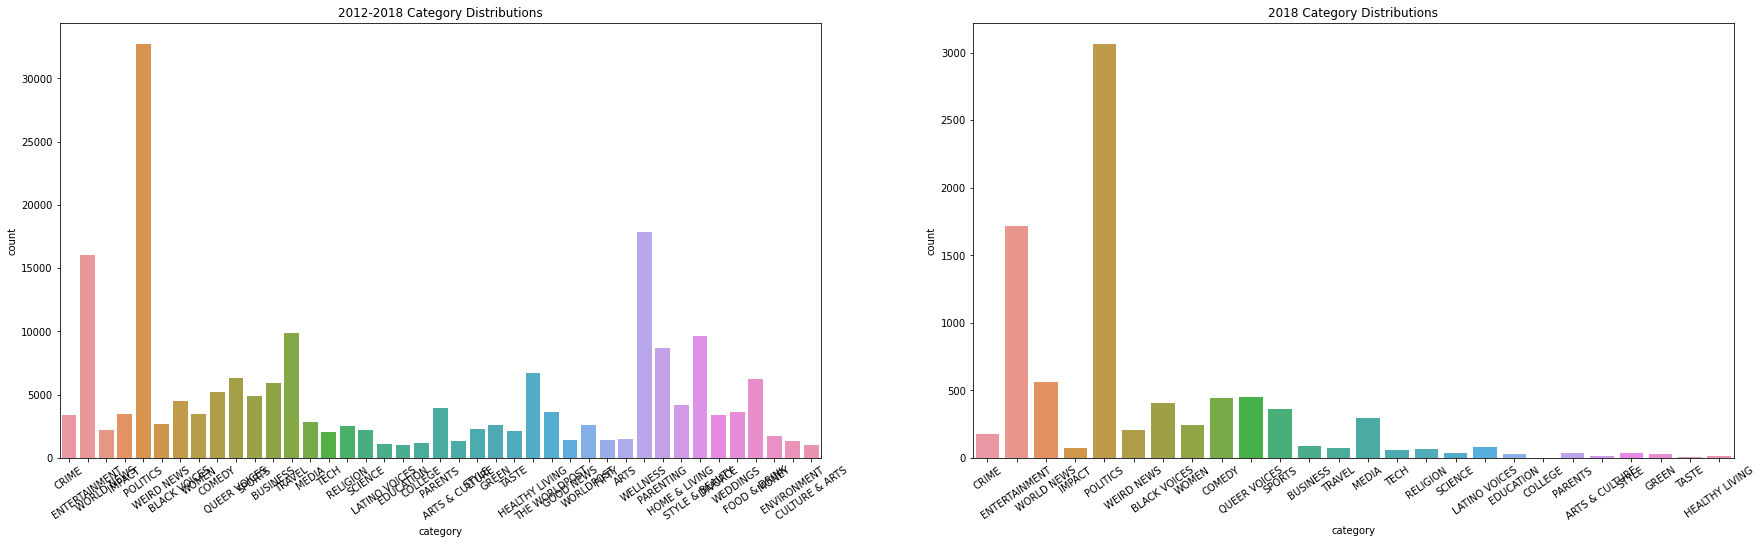

In [208]:
# Since we're eliminating articles from 2012-2017, let's see what differences between all years and articles just in 2018
plt.figure(figsize=(30,8))

plt.subplot(1,2,1)
plot1 = sns.countplot(data=df, x="category")
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=35)
plot1.set_title("2012-2018 Category Distributions")

plt.subplot(1,2,2)
plot2 = sns.countplot(data=huffpo_df, x="category")
plot2.set_xticklabels(plot2.get_xticklabels(),rotation=35)
plot2.set_title("2018 Category Distributions")

huffpo_df.head();

It looks like some categories were condensced or eliminated from sometime before 2018 to 2018.  This is likely due to restructuring within the media to change categories, emphasizing the need for continued up-to-date data for this classification model.  It also means any insights from this project aren't necessarily going to be relevant in the future if there's another change.

Overall distribution wise it looks like there are overall similar trends with the categories we are able to compare.

In [209]:
# Checking how many months are covered in 2018
huffpo_df.month.unique()

array([5, 4, 3, 2, 1])

We only have Jan-May covered here.

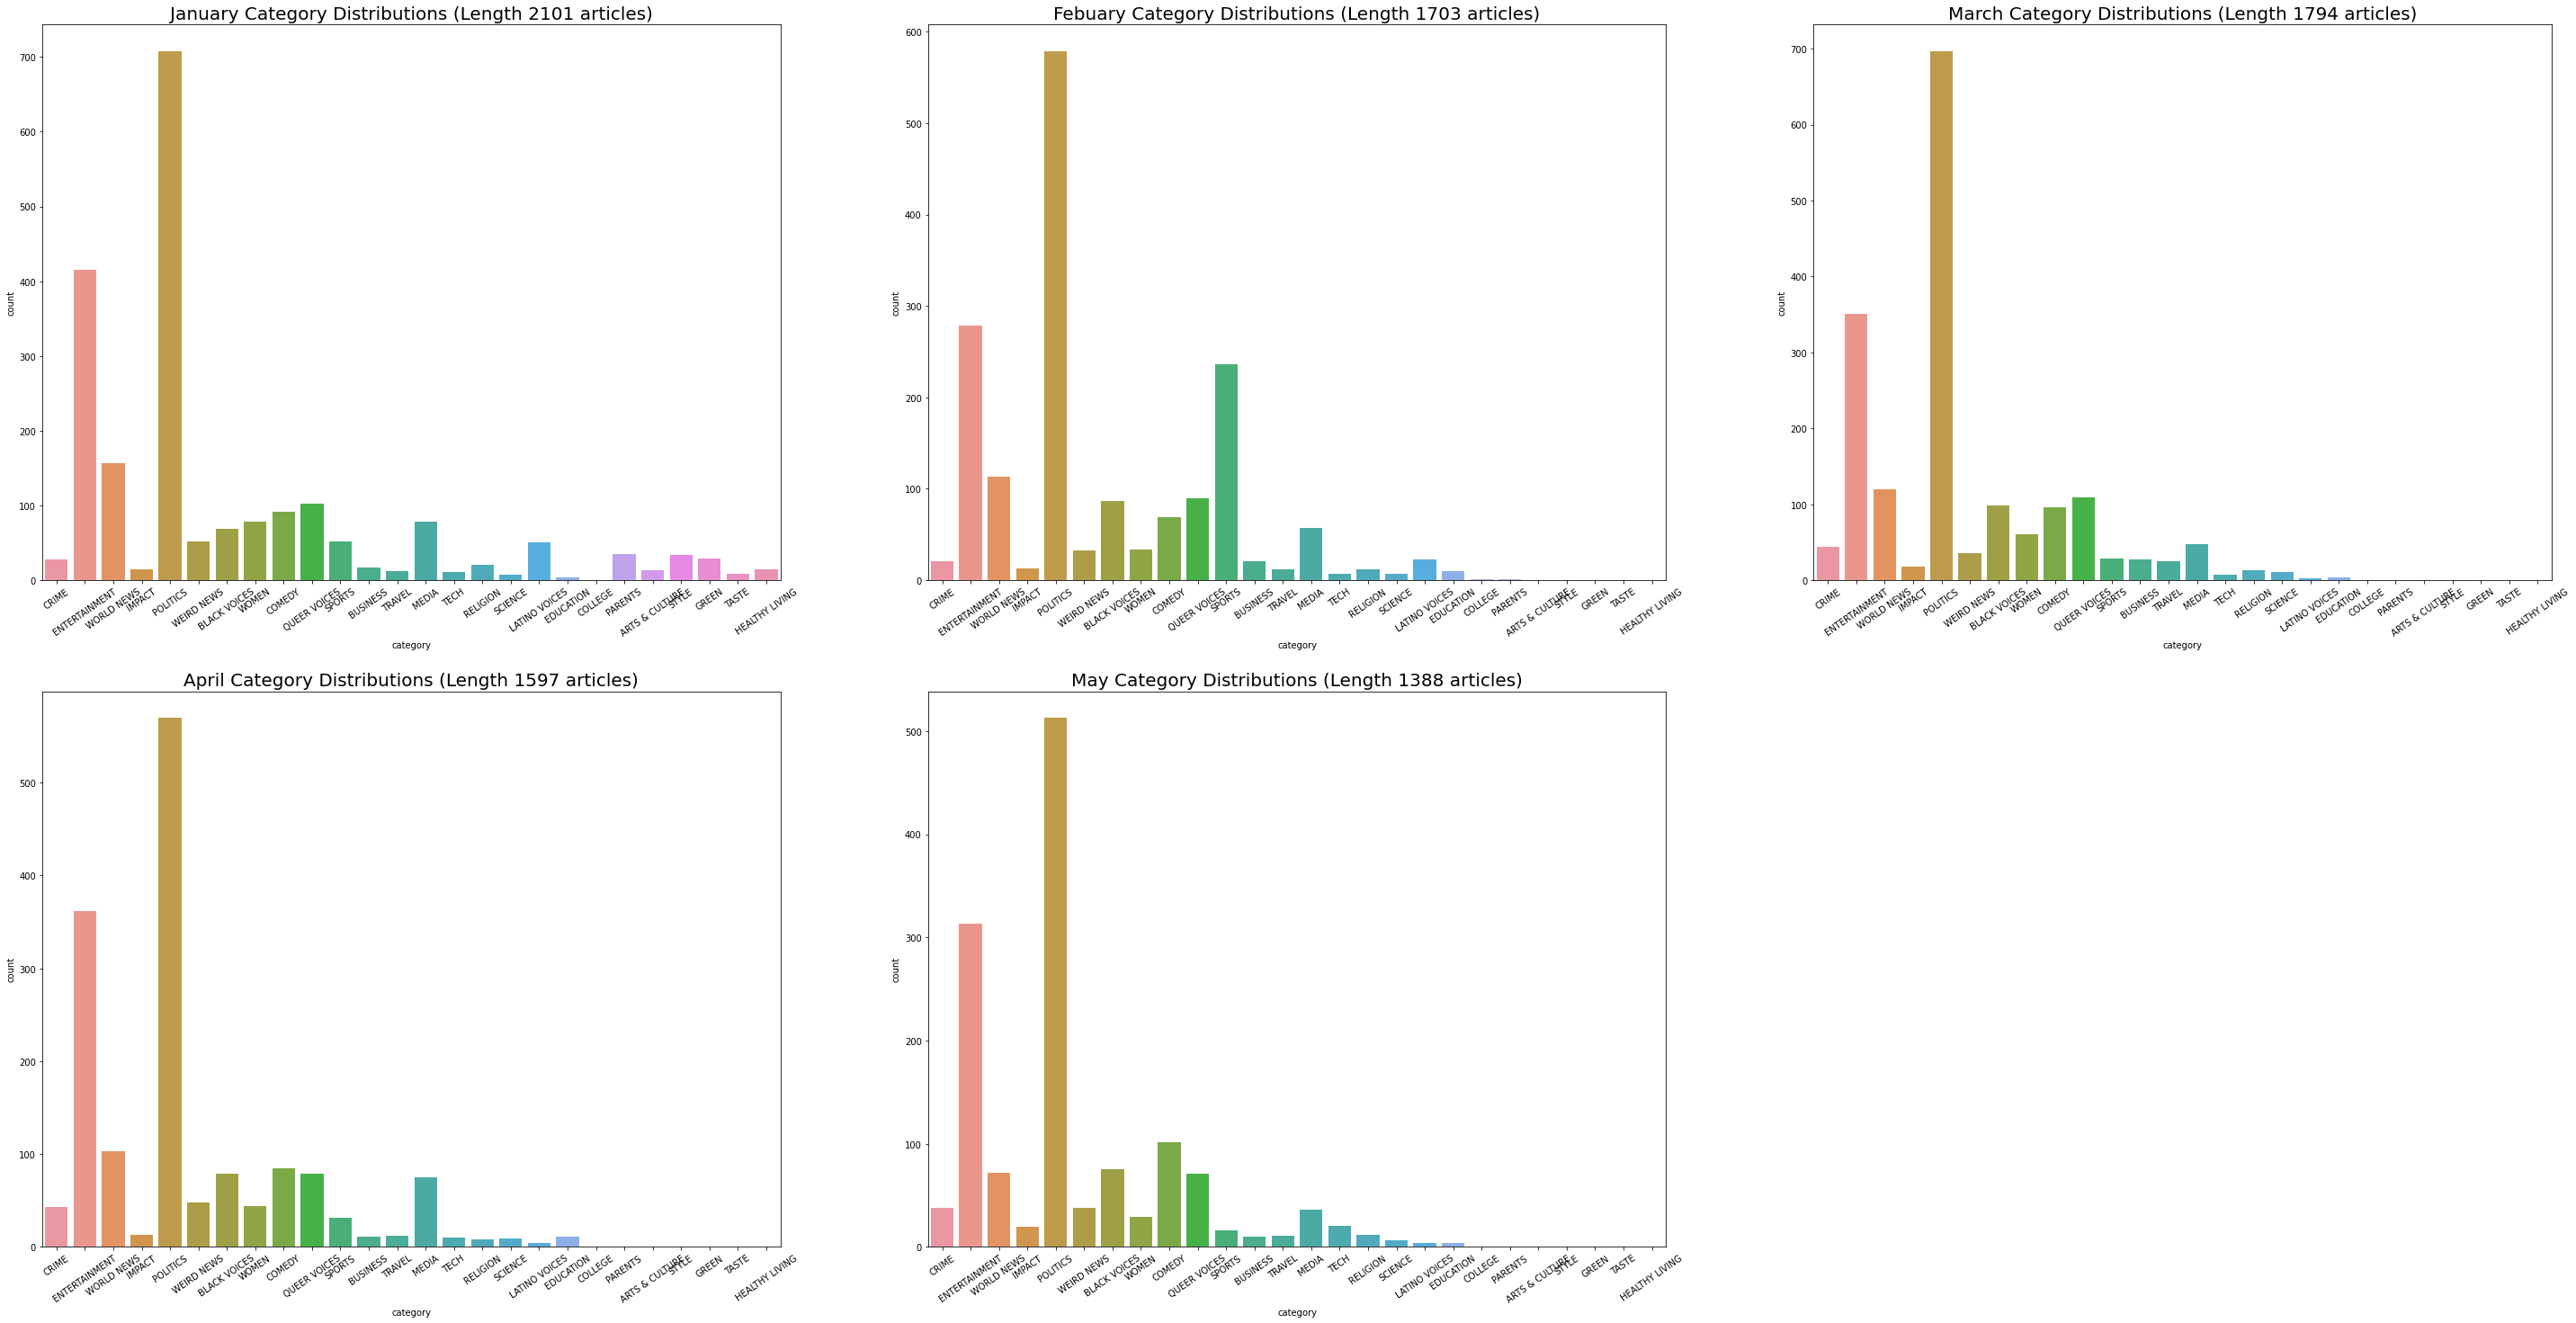

In [7]:
# Hueing by month
plt.figure(figsize=(50,25))

huffpo_df.replace([1,2,3,4,5], ["January", "Febuary", "March", "April", "May"], inplace=True)

i=1
for month in ["January", "Febuary", "March", "April", "May"]: # Inputting list so charts appear in sequential order

  month_df = huffpo_df[huffpo_df["month"] == month]

  plt.subplot(2,3,i)
  ax=sns.countplot(data=month_df, x="category", order=huffpo_df["category"].unique())
  ax.set_xticklabels(ax.get_xticklabels(),rotation=35)
  ax.set_title("{} Category Distributions (Length {} articles)".format(month,month_df.shape[0]), fontdict={'fontsize':20})

  i+=1

#NOTE: The categories are centered immediately below their respective tick

There are only 5 months represented here; therefore, this model may show poorer performance when classifying any prior or subsequent years for articles in the unrepresented months.  

Politics and entertainment dominate coverage in all months, though by different amounts.  However, there do seem to be some different trends across different months.  Some stray observations:


*   There's a slight increase in comedy articles during April (April Fool's Day) and a large increase in sports articles in Febuary (Superbowl and leadup to March Madness) but there doesn't seem to be an increase in Black Voices articles in Febuary (Black History Month)
*   There are NO college related articles.  This may be a discontinued category from previous years
*   After January, there are few to no articles involving more "lifestyle" focused articles (parents, green, healthy living), along with a signficant decrease in Latino Voices.

All of the above suggests that making seperate models for each month may increase classification accuracy.

In [211]:
# Quick look at any common headlines
headlines = Counter(huffpo_df["clean_headline"].values)
print("Top 10 Most popular headlines (lemmatized):")
print("------------------")
headlines.most_common(10)

Top 10 Most popular headlines (lemmatized):
------------------


[('funniest Tweets woman week', 19),
 ('watch Amazon Prime New week', 5),
 ('watch Hulu New week', 5),
 ('movie come Netflix week', 4),
 ('Good Movie Netflix add week', 3),
 ('funniest Tweets parent week', 3),
 ('year month', 2),
 ('rest world show March life', 2),
 ('dead hostage Standoff end California Veterans home', 2),
 ('Florida Lawmaker School Shooting Survivors adult law', 2)]

In [212]:
#These are the only repeat headlines.  Do they happen across categories?


top_headlines = []
for i in range(10):
  top_headlines.append(headlines.most_common(10)[i][0])

headline_df = huffpo_df[huffpo_df["clean_headline"].isin(top_headlines)]

#Just checking Dataframe
headline_df

,category,month,clean_headline,clean_desc
7,ENTERTAINMENT,May,watch Amazon Prime New week,great mini series join week
9,ENTERTAINMENT,May,watch Hulu New week,get recent Academy Award win movie
68,WOMEN,May,funniest Tweets woman week,welcome adulthood favorite spatula
295,ENTERTAINMENT,May,movie come Netflix week,option week include new Gillian Jacobs movie
352,ENTERTAINMENT,May,watch Amazon Prime New week,new Natalie Dormer
366,ENTERTAINMENT,May,watch Hulu New week,review documentary bourbon
429,WOMEN,May,funniest Tweets woman week,coffee mug lot heavy lifting come personality ...
629,ENTERTAINMENT,May,movie come Netflix week,Surprise Netflix add pretty good sci fi movie
698,ENTERTAINMENT,May,watch Hulu New week,movie worth watch lot time live
699,ENTERTAINMENT,May,watch Amazon Prime New week,movie worth see star Salma Hayek


It doesn't appear any of the most frequent "headlines" appear across categories.

---
---

**Modeling**

---
---

I'm going to run through all techniques starting with headlines, then will do the same for the short descriptions.  I'll only be running Logistic Regression models, as the small size of my dataset seems to suggest the quicker speed and better handling of overfitting diminish possible small advantages gained by using other classification models.

---

**Headlines**

---

Bag of Words

---

In [13]:
# Ngrams of 1 for headlines
vectorizer = CountVectorizer(analyzer='word')
X = vectorizer.fit_transform(huffpo_df["clean_headline"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
headlines_ngram1 = pd.concat([bow_df, huffpo_df[["clean_headline", "category"]]], axis=1)


headlines_ngram1.head(2)

,10th,11th,15s,18th,1970,1980,19th,1st,200,20th,21st,25th,2nd,30th,36dd,3rd,4th,52,5th,64,6th,76ers,80,90,90s,90th,aaaaaah,aaliyah,aaron,abandon,abandoned,abba,abbi,abbott,abby,abc,abducted,abide,ability,able,...,youtube,youtuber,yuhua,yup,yura,yuzuru,yvette,yvonne,zach,zachary,zagitova,zahara,zainab,zandy,zayn,zealand,zellweger,zendaya,zero,zeroes,zeta,zika,zimmerman,zing,zinger,zinging,zings,zinke,zip,zipper,zodiac,zombie,zone,zoo,zoolander,zuckerberg,zuma,zylka,clean_headline,category
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mass shooting Texas Week tv,CRIME
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Smith Joins Diplo Nicky Jam World Cup official...,ENTERTAINMENT


In [14]:
# Get scores for ngram=1 models
X = np.array(headlines_ngram1.drop(['clean_headline','category'], 1))
Y = headlines_ngram1['category'].iloc[:,1] # Need to specify because one of the words in the headlines is 'category'

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=25)


lr = LogisticRegression()
lr.fit(X_train, y_train)

print("-------------------Logistic Regression Scores:Ngrams 1----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


-------------------Logistic Regression Scores:Ngrams 1----------------------
Training set score: 0.9778619283425576

Test set score: 0.6814210832847991


NOTE: I ran a model with Ngrams of 1&2 but the session repeatedly crashed my system.  However, I was able to get some reults, and the ngrams with range 1-2 performed the same with the logistic regression model and worse on the random forest one.  Given the nature of headlines, context likely doesn't matter as much as the actual words themselves, so limiting exploration to ngrams=1 makes sense moving forward.

I'm also therefore going to not look at TF-ID vectors and continue on to apply word2vec



Word2vec

---

In [215]:
# Get model for headlines using word2vec

w2v = Word2Vec(huffpo_df["clean_headline"],workers=4,min_count=1,window=6,
               sg=1,#skipgram seems the better option due to limit of headline corpus
               sample=1e-3,
               size=26, #number of categories
               hs=1)

In [216]:
word2vec_arr = np.zeros((huffpo_df.shape[0],26))

for i, word in enumerate(huffpo_df["clean_headline"]):
    word2vec_arr[i,:] = np.mean([w2v[lemma] for lemma in word], axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [218]:
word2vec_arr = pd.DataFrame(word2vec_arr)
headlines_w2v = pd.concat([huffpo_df[["category", "clean_headline"]],word2vec_arr], axis=1)
headlines_w2v.dropna(inplace=True)

headlines_w2v.head(3)

,category,clean_headline,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,CRIME,Mass shooting Texas Week tv,-0.435702,0.082939,0.088856,-0.053991,0.078527,0.224401,0.085873,-0.028490,-0.075190,-0.093647,-0.037417,-0.062236,-0.071631,-0.113745,-0.238836,0.030733,-0.076839,0.166964,0.160613,-0.259558,0.137662,0.238786,0.112150,0.143549,0.122927,-0.088095
1,ENTERTAINMENT,Smith Joins Diplo Nicky Jam World Cup official...,-0.454964,0.063510,0.141915,-0.048144,0.044924,0.233424,0.060597,-0.039479,-0.081595,-0.111205,-0.069657,-0.071059,-0.113057,-0.111739,-0.219334,0.011336,-0.082232,0.160920,0.143553,-0.250389,0.140945,0.206918,0.096558,0.093758,0.172588,-0.055896
2,ENTERTAINMENT,Hugh Grant marrie Time Age,-0.441721,0.041422,0.164913,-0.083335,0.040049,0.203443,0.087366,-0.056176,-0.059446,-0.110502,-0.058293,-0.069654,-0.114200,-0.095468,-0.204690,0.009201,-0.058444,0.213637,0.170983,-0.245015,0.161651,0.197036,0.136984,0.120948,0.129538,-0.075929


In [219]:
# Get scores for word2vec model
X = np.array(headlines_w2v.drop(['clean_headline','category'], 1))
Y = headlines_w2v['category']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=25)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)

print("-------------------Logistic Regression Scores:Word2vec ----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores:Word2vec----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


-------------------Logistic Regression Scores:Word2vec ----------------------
Training set score: 0.37625637290604513

Test set score: 0.38031450203843914
----------------------Random Forest Scores:Word2vec----------------------
Training set score: 1.0

Test set score: 0.4280722189866045


The vectors perform worse than bag of words, likely due to not having enough examples to base vectors off of.  These scores would likely be better if I included additional years in the data.

 I'm guessing they'll perform better on the longer and more varied short descriptions.  For now, I'll consider my BoW model my best option when referencing just headlines.

---
**Short Descriptions**

---

Given the strenous computational power for BoW, I'm only going to use vector constructing methods for the short descriptions.

In [220]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True, ngram_range=(1,2))


# Applying the vectorizer
X = vectorizer.fit_transform(huffpo_df["clean_desc"])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
vectors = pd.concat([tfidf_df, huffpo_df[["clean_desc", "category"]]], axis=1)

In [221]:
# Get description based scores for tfid model
X = np.array(vectors.drop(['clean_desc','category'], 1))
Y = vectors['category'].iloc[:,1]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=25)

In [222]:
# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)

print("-------------------Logistic Regression Scores: TFID ----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores: TFID ----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


-------------------Logistic Regression Scores: TFID ----------------------
Training set score: 0.6168074570346636

Test set score: 0.49912638322655795
----------------------Random Forest Scores: TFID ----------------------
Training set score: 0.9861637052140985

Test set score: 0.5084449621432732


These scores don't match with the original BoW model while using headlines.  I'm going to try word2vec with short descriptions as a final comparison point.

In [223]:
# Get model for headlines using word2vec

w2v_desc = Word2Vec(huffpo_df["clean_desc"],workers=4,min_count=1,window=6,
               sg=0,#Continuous bag of words seems a better option given variation within a description
               sample=1e-3,
               size=26, #number of categories
               hs=1)

In [224]:
word2vec_arr_desc = np.zeros((huffpo_df.shape[0],26))

for i, word in enumerate(huffpo_df["clean_desc"]):
    word2vec_arr_desc[i,:] = np.mean([w2v_desc[lemma] for lemma in word], axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [225]:
word2vec_arr_desc = pd.DataFrame(word2vec_arr_desc)
headlines_w2v_desc = pd.concat([huffpo_df[["category", "clean_desc"]],word2vec_arr_desc], axis=1)
headlines_w2v_desc.dropna(inplace=True)

headlines_w2v_desc.head(3)

,category,clean_desc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,CRIME,leave husband kill child day America,0.075703,0.008978,-0.387221,0.043541,0.104583,-0.347720,0.562684,-0.144071,0.265154,0.250301,0.147947,0.253235,0.355037,-0.042853,-0.093137,-0.107737,-0.019276,0.092390,0.093295,-0.161621,0.181127,0.164690,-0.093613,-0.127535,0.040663,-0.205919
1,ENTERTAINMENT,course song,0.138617,0.156752,-0.523052,-0.076049,0.017370,-0.411633,0.628968,-0.227826,0.189320,0.126052,0.083032,0.171308,0.607713,0.033907,-0.072192,-0.328134,0.070574,0.024360,0.253910,0.013560,0.328373,0.212633,-0.042429,-0.162866,0.129377,-0.245673
2,ENTERTAINMENT,actor longtime girlfriend Anna Eberstein tie k...,0.046199,-0.041275,-0.440512,0.047896,0.007142,-0.379645,0.648960,-0.170527,0.258837,0.226288,0.098079,0.198751,0.463701,-0.112397,-0.091278,-0.206523,-0.023768,0.123109,0.134076,-0.078815,0.184801,0.060262,-0.120159,-0.106410,-0.039816,-0.210484


In [226]:
# Get scores for word2vec model
X = np.array(headlines_w2v_desc.drop(['clean_desc','category'], 1))
Y = headlines_w2v_desc['category']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=25)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)

print("-------------------Logistic Regression Scores:Word2vec ----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores:Word2vec----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


-------------------Logistic Regression Scores:Word2vec ----------------------
Training set score: 0.3736842105263158

Test set score: 0.3719298245614035
----------------------Random Forest Scores:Word2vec----------------------
Training set score: 0.9960526315789474

Test set score: 0.38596491228070173


These did even worse than the word2vec model using only headlines!

The BoW model produced the highest training and test scores, so I'm going to tune it in a few passes.  I'm going to focus one pass by adjusting the inverse regularization and tolerance 

In [ ]:
# Bag_of_Words: 1st pass
X = np.array(headlines_ngram1.drop(['clean_headline','category'], 1))
Y = headlines_ngram1['category'].iloc[:,1] # Need to specify because one of the words in the headlines is 'category'

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=25)


parameters = {'C': [0.001, 0.1, 1,],
              'tol':[.0001,.001,.01]
              }

lr = LogisticRegression()
lr_tuned = GridSearchCV(lr, parameters, cv=3)
lr_tuned.fit(X_train, y_train)

In [14]:
print("-------------------Logistic Regression Scores:TUNED Ngrams 1----------------------")
print('Training set score:', lr_tuned.score(X_train, y_train))
print('Test set score:', lr_tuned.score(X_test, y_test))
print("Best parameters:{}".format(lr_tuned.best_params_))

-------------------Logistic Regression Scores:TUNED Ngrams 1----------------------
Training set score: 0.9778619283425576
Test set score: 0.6814210832847991
Best parameters:{'C': 1, 'tol': 0.0001}


Default parameters provide the best scores, so I won't change them

I also want to see if this model improves by removing the error penalty; I haven't seen this applied yet with text data

In [15]:
lr_none = LogisticRegression(penalty='none')
lr_none.fit(X_train,y_train)

print("-------------------Logistic Regression Scores:NO regularization penalty----------------------")
print('Training set score:', lr_none.score(X_train, y_train))
print('Test set score:', lr_none.score(X_test, y_test))

-------------------Logistic Regression Scores:NO regularization penalty----------------------
Training set score: 1.0
Test set score: 0.6703552708211997


Definite (and unsurprising) result of overfitting

**Conclusions**

---

My Bag of Words model was able to correctly classify the articles 68% of the time with a Logistic Regression classification method.  In terms of prep needed to get to this point, this is a pretty strong start for further refining.

Given the limited space in which to quickly express thoughts, headlines seem like they are a better reference for classifying an article compared to a short description, which has allowance to deviate in tone and be more nuanced. 

I believe including additional years worth of data would improve the accuracy, along with creating varying models for different months to account for possible biases from imbalances, as seen during data exploration.  Giving different weights to different authors may also lead to some additional insight, as personal writing style could translate to how headlines are crafted (though on the other hand these are likely all approved by a small team of editors, therby eliminating personal voice).